In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Functions

In [182]:
def make_B(N, N_over_p, T, mode="even"):
    """
    Creates a matrix which undersamples a data vector of length NT.
    
    Args:
        N (int): Length of the of the original signal.
        N_over_p (int): Factor of undersampling which results in 
        copies of undersampled data which is of length p. 
        Must be a whole number.
        T (int): Number of coils s.t. the whole signal is of length NT.
        mode: Method by which the data is undersampled. May be
        one in every N/p samples, the center N/p samples, or a random
        selection of N/p samples.
    
    Returns:
        B_matrix (2D ndarray): A real matrix which is of size TpxTN
        and T length-N signals into T length-p signals. The matrix is
        sparse: pT values are ones and the rest are zeros.
    """
    if mode == "even":
        keep_k = np.arange(N)[::N_over_p]
    if mode == "center":
        approx_p = N//N_over_p
        k1 = (N//2) - (approx_p//2)
        k2 = (N//2) + (approx_p//2) + (approx_p%2)
        keep_k = np.arange(N)[k1:k2]
    if mode == "random" or mode == "rand":
        approx_p = N//N_over_p
        keep_k = np.random.choice(np.arange(N), size=approx_p, replace=False)
        keep_k.sort()
    B_p = np.eye(N)[keep_k,:]
    p = B_p.shape[0]
    B_matrix = np.zeros((T*p, T*N))
    for i in range(T):
        B_matrix[i*p:(i+1)*p, i*N:(i+1)*N] = B_p
    return B_matrix

In [183]:
def make_F(N):
    """
    Creates a matrix which performs a Fourier transform on
    a 1D signal.
    
    Args:
        N (int): Length and height of the NxN Fourier transform
        matrix. Should be greater than or equal to the length
        of the signal.
    
    Returns:
        F_matrix (2D ndarray): A complex matrix which, when multiplied
        by a Nx1 signal, results in the Nx1 Fourier transform of that
        signal.
    """
    ind_matrix = np.indices((N,N))
    phase_matrix = 2*np.pi*(ind_matrix[0] * ind_matrix[1])/N
    F_matrix = np.cos(phase_matrix) - 1j * np.sin(phase_matrix)
    return F_matrix

In [184]:
def make_C(C_tuple):
    """
    Creates a matrix of multiple sensitivity maps of the same
    dimensionality stacked on top of each other in the 0th axis.
    
    Args:
        C_tuple: Tuple of T flattened sensitivity maps of the same length N.
        The function returns early if their shapes are not the same.
    
    Returns:
        C_ret: The sensitivity map matrices with dimensionality TNxN.
    """
    C_0_shape = C_tuple[0].shape
    for C in C_tuple:
        if C.shape != C_0_shape:
            print("Mismatch in shape!")
            return
    C_ret = np.diagflat(C_tuple[0])
    for C in C_tuple[1:]:
        C_ret = np.concatenate((C_ret, np.diagflat(C)), axis=0)
    return C_ret

## 1D Toy Example

In [180]:
# Simulate a simple 10 Hz sine wave with noise over 1 s
sample_rate = 200  # Hz
t = np.linspace(0, 1, sample_rate, endpoint=False) #time vector from 0 to 1 with sample rate data points
signal = np.sin(2 * np.pi * 10 * t) + 0.2 * np.random.normal(size=t.shape)  # frequency = 10 Hz

In [181]:
undersampling_factor = 4  # take every 4th sample
t_undersampled = t[::undersampling_factor] 
signal_undersampled = signal[::undersampling_factor]

In [185]:
# Make a B vector to perform 1/3 sampling of size 200 vector, times 3
B_67p200_600 = make_B(200,3,3)

In [186]:
# Make a 200x200 Fourier Transform vector, times three
F_200 = make_F(200)
F_200_600 = np.zeros((600,600), dtype='complex128')
F_200_600[0:200,0:200] = F_200
F_200_600[200:400,200:400] = F_200
F_200_600[400:,400:] = F_200

In [187]:
# Make a 400 sample-long Gaussian curve to base sensitivity maps off of
gauss_x = np.linspace(0,2,200*2)
gauss_mean = 1
gauss_std = 0.3
mygauss = 1 * np.exp(-np.power((gauss_x-gauss_mean), 2) / (2*gauss_std**2))

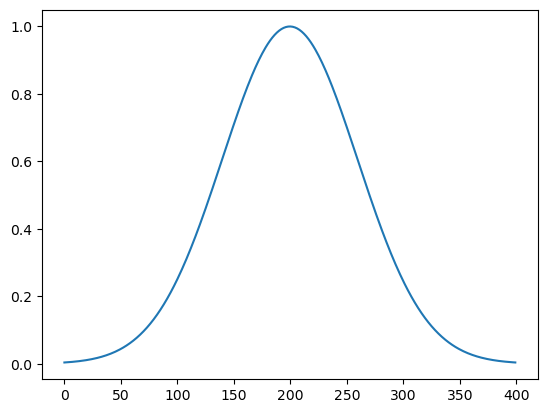

In [188]:
plt.plot(mygauss)

In [189]:
# Make three sensitivity maps from different slices of the same Gaussian
# curve. There are few nonzero values here, but theoretically reconstruction
# should work as long as each data point is covered at least once.
C1 = mygauss[:200]
C2 = mygauss[100:300]
C3 = mygauss[200:]
C_maps = (C1, C2, C3)
C_c = make_C(C_maps)

In [190]:
#Owen
E = B_67p200_600 @ F_200_600 @ C_c # Encoding matrix of shape (num_coils*p, num_coils*num_samples)
d = E @ signal # Acquired data vector of shape (num_coils*p, )

lmbda = 0.01 #Regularization

EH = E.conj().T  # Hermitian transpose
rho_hat2 = np.linalg.inv(EH @ E + lmbda * np.eye(E.shape[1])) @ EH @ d #Analytical solution

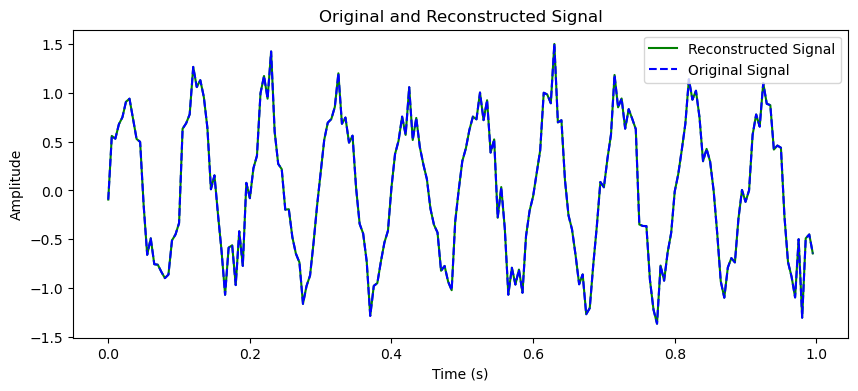

In [191]:
plt.figure(figsize=(10, 4))
plt.plot(t, np.real(rho_hat2), label="Reconstructed Signal", linestyle='-', color='g')
plt.plot(t, signal, label="Original Signal", linestyle='--', color='b')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original and Reconstructed Signal")
plt.legend()
plt.show()

In [192]:
# As shown in Robert's calculations, the gradient
# of the loss function w.r.t. the image is:
#   -2*EH*d + 2(EH*E + lambda*I)rho

# Starting value
rho = np.ones(200)

iters = 1001
#learn_rate = 10e-4
# Blows up around 6e-3+4e-4
learn_rates2 = np.concatenate((np.array([5e-3, 6e-3, 6.1e-3, 6.2e-3]), np.arange(6.3e-3, 6.355e-3, 0.005e-3)))
ks = []
learn_errors2 = []
lambda_I = 0.3 * np.eye(rho.shape[0])
error = []
error_thres = 1e-2
save_iter = np.concatenate((np.arange(0,10),np.arange(10,100,10), np.arange(100,iters,100)))
save_rho = []
# Perform GD for different learning rates, stopping at 1000 iterations or
# when error reaches a certain upper/lower bound
for learn_rate2 in learn_rates2:
    rho = np.ones(200)
    error = []
    # Iterate over GD steps
    for k in range(iters):
        # Save post-update error and rho_k
        temp_error = np.mean(np.abs(np.square(d - E@rho)))
        error.append(temp_error)
        if learn_rate2 == learn_rates2[0]:
            if k in save_iter:
                save_rho.append(rho)
        
        # update
        if temp_error < error_thres:
            break
        if temp_error > 1e3:
            break
        rho = rho - learn_rate2 * (-2*EH@d + 2*(EH@E + lambda_I) @ rho)
    learn_errors2.append(error)

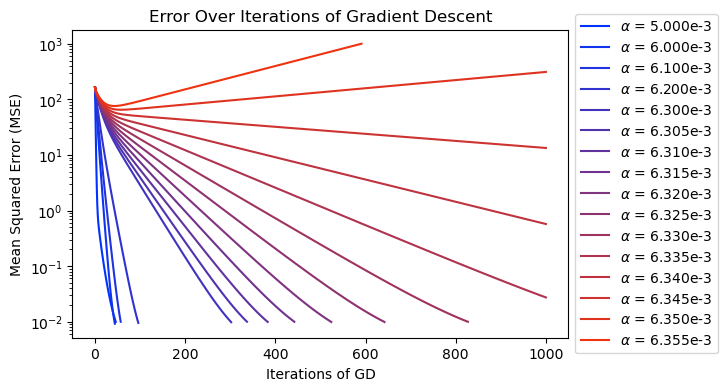

In [193]:
plt.figure(figsize=(8, 4))
ax = plt.subplot(111)
for ii in range(len(learn_rates2)):
    plt.plot(np.array(learn_errors2[ii]), label=r'$\alpha$ = '+f'{((round(learn_rates2[ii]*1e6))/1000):.3f}'+'e-3',
            color=(ii/len(learn_rates2), 0.2, 1-(ii/len(learn_rates2))))
plt.yscale('log')
plt.xlabel('Iterations of GD')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Error Over Iterations of Gradient Descent')
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncols=1)
#plt.legend(loc='right')
plt.show()

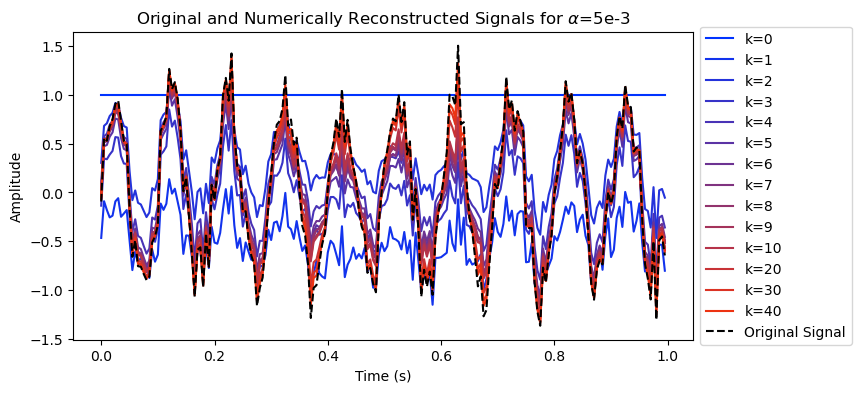

In [194]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(111)
for ii in range(len(save_rho)):
    k = save_iter[ii]
    temp_rho = save_rho[ii]
    plt.plot(t, np.real(temp_rho), label=f"k={k}", linestyle='-', color=(ii/len(save_rho), 0.2, 1-(ii/len(save_rho))))
plt.plot(t, signal, label="Original Signal", color='black', linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(r"Original and Numerically Reconstructed Signals for $\alpha$=5e-3")

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncols=1)
#plt.legend(loc='right')
plt.show()

In [195]:
# As shown in Robert's calculations, the gradient
# of the loss function w.r.t. the image is:
#   -2*EH*d + 2(EH*E + lambda*I)rho

# Starting value
rho = np.ones(200)

iters = 40
#learn_rate = 10e-4
# Blows up around 6e-3+4e-4
learn_rates = [6.45e-3]
ks = []
learn_errors = []
lambda_I = 0.3 * np.eye(rho.shape[0])
error = []
error_thres = 1e-2
save_iter = np.arange(0,40)
save_rho = []
save_step = []
# Perform GD for a learning rate which diverges quickly
for learn_rate in learn_rates:
    rho = np.ones(200)
    error = []
    # Iterate over GD steps
    for k in range(iters):
        # Save post-update error and rho_k
        temp_error = np.sum(np.abs(np.square(d - E@rho)))
        error.append(temp_error)
        if k in save_iter:
            save_rho.append(rho)
            save_step.append(learn_rate * (-2*EH@d + 2*(EH@E + lambda_I) @ rho))
        
        # update
        if temp_error < error_thres:
            break
        #if temp_error > 1e3:
         #   break
        rho = rho - learn_rate * (-2*EH@d + 2*(EH@E + lambda_I) @ rho)
    learn_errors.append(error)

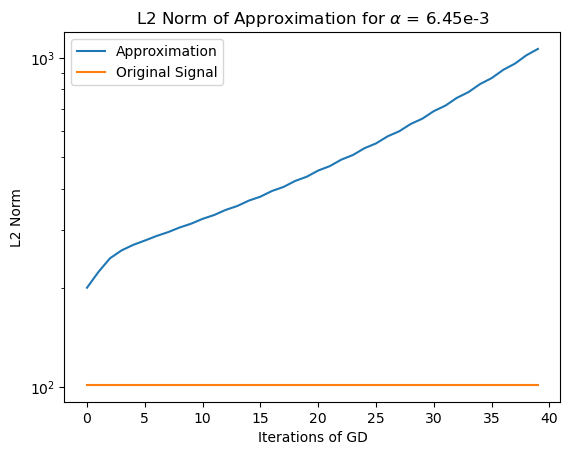

In [196]:
# Plot L2 norms, possibly including square error, over iterations
# to show behavior of divergence
plt.figure()
rho_energy = []
for temp_rho in save_rho:
    rho_energy.append(np.sum(np.abs(np.square(temp_rho))))
step_energy = []
for temp_step in save_step:
    step_energy.append(np.sum(np.abs(np.square(temp_step))))
rho_energy = np.array(rho_energy)
step_energy = np.array(step_energy)
plt.plot(rho_energy, label="Approximation")
#plt.plot(step_energy, label="Steps")
#plt.plot(np.array(learn_errors[0]), label='Error')
plt.plot(np.sum(np.abs(np.square(signal)))*np.ones(rho_energy.shape), label="Original Signal")
plt.xlabel('Iterations of GD')
plt.ylabel('L2 Norm')
plt.yscale('log')
plt.title(r'L2 Norm of Approximation for $\alpha$ = 6.45e-3')
plt.legend()

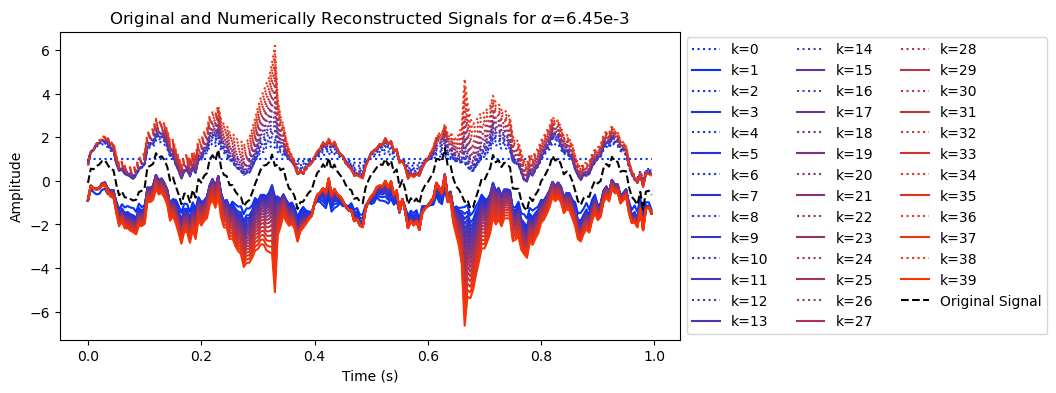

In [197]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(111)
for ii in range(len(save_rho)):
    k = save_iter[ii]
    temp_rho = save_rho[ii]
    if ii % 2:
        plt.plot(t, np.real(temp_rho), label=f"k={k}", linestyle='-', color=(ii/len(save_rho), 0.2, 1-(ii/len(save_rho))))
    else:
        plt.plot(t, np.real(temp_rho), label=f"k={k}", linestyle='dotted', color=(ii/len(save_rho), 0.2, 1-(ii/len(save_rho))))
plt.plot(t, signal, label="Original Signal", color='black', linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(r"Original and Numerically Reconstructed Signals for $\alpha$=6.45e-3")

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncols=3)
#plt.legend(loc='right')
plt.show()

## 1D Chirp Example and Matrices
### (For Slideshow)

In [198]:
F_200 = make_F(200)

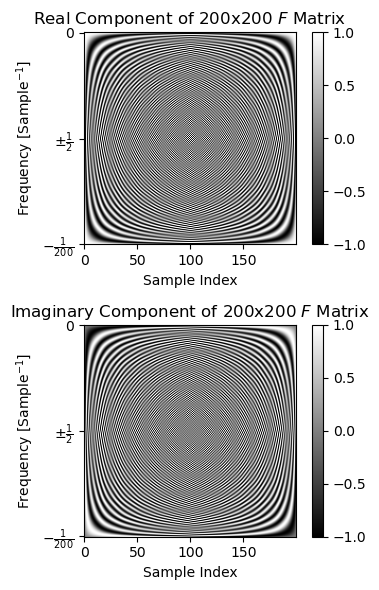

In [199]:
# Visualize the real and imaginary components of the Fourier
# Transform matrix.
fig, ax = plt.subplots(nrows=2, figsize=(4,6))
ax[0].set_title(r"Real Component of 200x200 $F$ Matrix")
ax[0].set_xlabel("Sample Index")
ax[0].set_ylabel(r"Frequency [Sample$^{-1}$]")
ax[0].set_yticks([0,100,199],labels=["0", r"$\pm \frac{1}{2}$", r"$-\frac{1}{200}$"])
temp = ax[0].imshow(np.real(F_200), cmap='gray')
fig.colorbar(temp)
ax[1].set_title(r"Imaginary Component of 200x200 $F$ Matrix")
ax[1].set_xlabel("Sample Index")
ax[1].set_ylabel(r"Frequency [Sample$^{-1}$]")
ax[1].set_yticks([0,100,199],labels=["0", r"$\pm \frac{1}{2}$", r"$-\frac{1}{200}$"])
temp = ax[1].imshow(np.imag(F_200), cmap='gray')
fig.colorbar(temp)
fig.tight_layout()

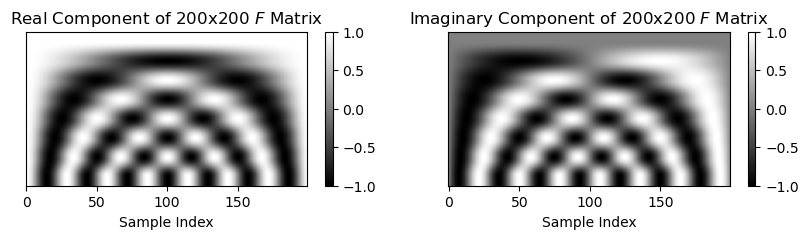

In [200]:
# Zoom in on the tops of the real and complex components
# of the matrix to show the phase difference
fig, ax = plt.subplots(ncols=2, figsize=(10,2))
ax[0].set_title(r"Real Component of 200x200 $F$ Matrix")
ax[0].set_xlabel("Sample Index")
ax[0].set_yticks([])
temp = ax[0].imshow(np.real(F_200[0:8]), cmap='gray', aspect='auto')
fig.colorbar(temp)
ax[1].set_title(r"Imaginary Component of 200x200 $F$ Matrix")
ax[1].set_xlabel("Sample Index")
ax[1].set_yticks([])
temp = ax[1].imshow(np.imag(F_200[0:8]), cmap='gray', aspect='auto')
fig.colorbar(temp)

In [201]:
# Make a few B-matrices using the presets of the function
# And different values of N/p
B_list = [[],[]]
B_list[0].append(make_B(200,2,1,mode='even'))
B_list[0].append(make_B(200,2,1,mode='center'))
B_list[0].append(make_B(200,2,1,mode='random'))
B_list[1].append(make_B(200,3,1,mode='even'))
B_list[1].append(make_B(200,3,1,mode='center'))
B_list[1].append(make_B(200,3,1,mode='random'))

In [202]:
B_modes_list = ['Every N/p', 'Center', 'Randomly Selected']
B_p_list = [100, 67]

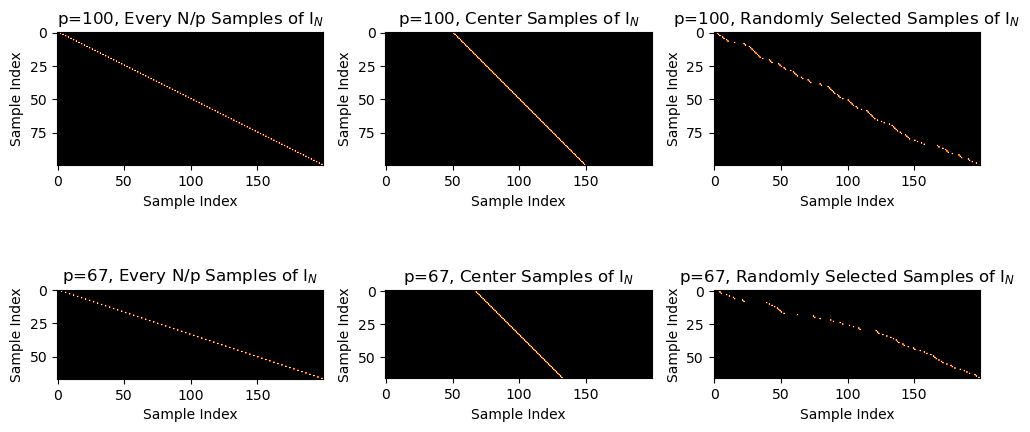

In [203]:
# Display the generated B-matrices
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10,5))
#fig.suptitle("Different Versions of B Matrix")
for i in range(2):
    for j in range(3):
        ax[i,j].set_title(f"p={B_p_list[i]}, {B_modes_list[j]} Samples of I$_N$")
        ax[i,j].set_xlabel("Sample Index")
        ax[i,j].set_ylabel(r"Sample Index")
        ax[i,j].imshow(B_list[i][j], cmap='afmhot')
fig.tight_layout()

Text(0, 0.5, 'Sample Index')

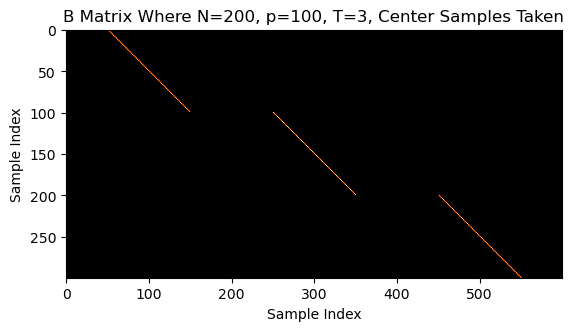

In [204]:
# Demonstrate that the function can make a big version of B
# for multi-coils
plt.title(f"B Matrix Where N=200, p=100, T=3, Center Samples Taken")
plt.imshow(make_B(200,2,3,mode='center'), cmap='afmhot')
plt.xlabel("Sample Index")
plt.ylabel("Sample Index")

Text(0.5, 1.0, 'Sensitivity Maps Where N=200, T=3')

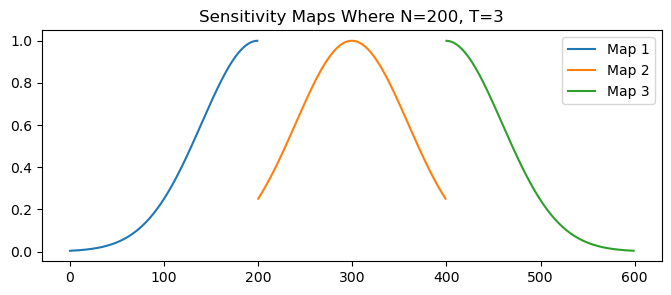

In [205]:
# Plot the different sensitivity maps on a line plot
plt.figure(figsize=(8,3))
plt.plot(np.arange(0,200), C_maps[0], label='Map 1')
plt.plot(np.arange(200,400), C_maps[1], label='Map 2')
plt.plot(np.arange(400,600), C_maps[2], label='Map 3')
plt.legend()
plt.title("Sensitivity Maps Where N=200, T=3")

Text(0, 0.5, 'Sample Index')

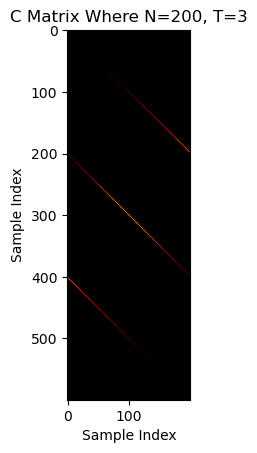

In [206]:
# Make an visualize the stacked sensitivity map matrices
plt.title(f"C Matrix Where N=200, T=3")
plt.imshow(make_C(C_maps), cmap='afmhot')
plt.xlabel("Sample Index")
plt.ylabel("Sample Index")

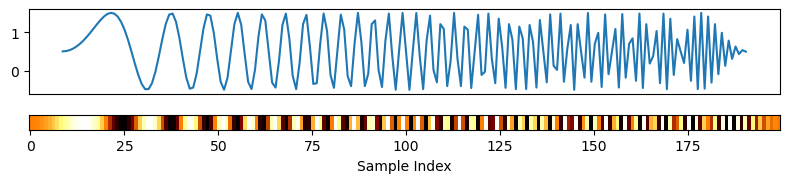

In [207]:
# Simple Example
# N = 200, T = 1, p = 100, undersample by taking every other frequency domain coefficient
c_N = 200
chirp_x = np.arange(c_N)
# Signal is a chirp from 0 to 1/2 1/sample
chirp_signal = np.sin(2 * np.pi * np.square(chirp_x) / (4 * c_N)) + 0.5
fig, ax = plt.subplots(nrows=2, figsize=(8,2))
ax[0].plot(chirp_signal)
ax[0].set_xticks([])
ax[1].imshow(np.array([chirp_signal,chirp_signal,chirp_signal,chirp_signal]), cmap='afmhot')
ax[1].set_xlabel("Sample Index")
ax[1].set_yticks([])
fig.tight_layout()

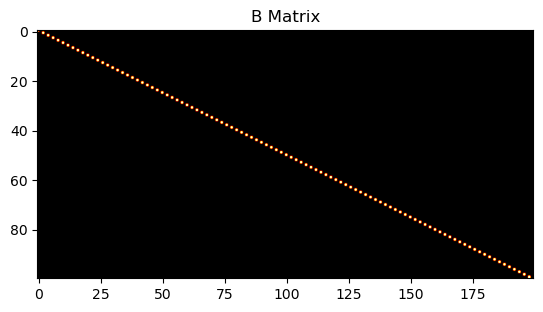

In [208]:
# B matrix for our simple example
chirp_B = make_B(200,2,1,mode='even')
plt.title(f"B Matrix")
plt.imshow(chirp_B, cmap='afmhot')

Text(0.5, 1.0, 'F Matrix (Real Component)')

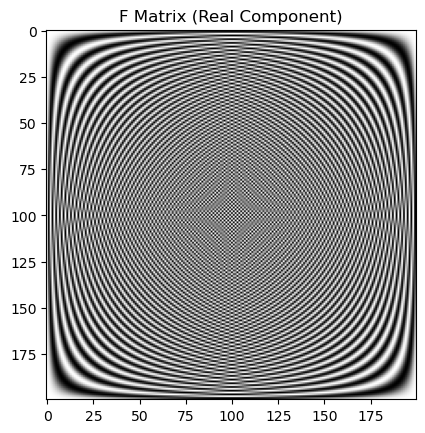

In [209]:
# Just the real component of the 200x200 Fourier Tranform matrix
F_200 = make_F(200)
plt.imshow(np.real(F_200), cmap='gray')
plt.title("F Matrix (Real Component)")

In [210]:
# Make a new Gaussian for the single sensitivity map for the chirp
# There are no nonzero values in this interval of this Gaussian
chirp_C_mean = 100
chirp_C_std = 70
chirp_gauss = 1 * np.exp(-np.power((chirp_x-chirp_C_mean), 2) / (2*chirp_C_std**2))
chirp_C = np.diagflat(chirp_gauss)

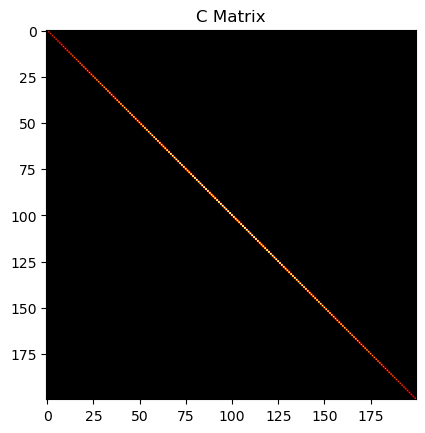

In [211]:
plt.title(f"C Matrix")
plt.imshow(chirp_C, cmap='afmhot')

In [212]:
# Perform each operation separately and save intermediate results
chirp_Cx = chirp_C @ chirp_signal
chirp_FCx = F_200 @ chirp_Cx
chirp_BFCx = chirp_B @ chirp_FCx

Text(0.5, 0, 'Sample Index')

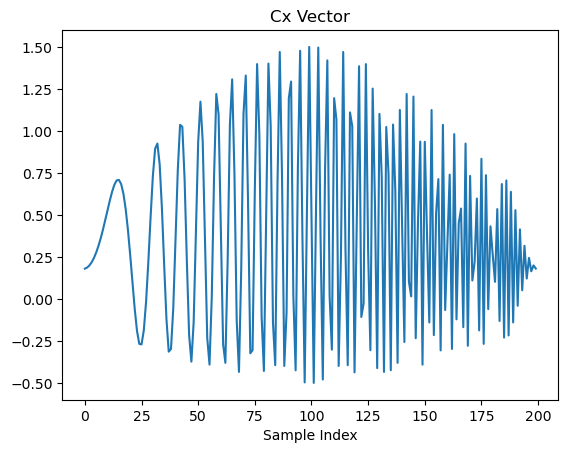

In [213]:
plt.title(f"Cx Vector")
plt.plot(chirp_Cx)
plt.xlabel("Sample Index")

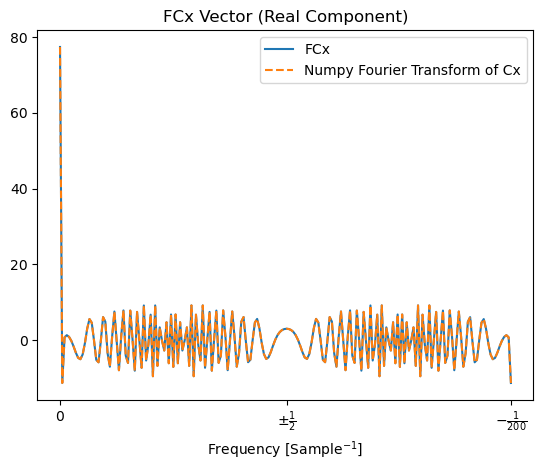

In [214]:
plt.title(f"FCx Vector (Real Component)")
plt.plot(np.real(chirp_FCx), label="FCx")
plt.plot(np.real(np.fft.fft(chirp_Cx)), linestyle='--', label="Numpy Fourier Transform of Cx")
plt.xlabel(r"Frequency [Sample$^{-1}$]")
plt.xticks([0,100,199], labels=['0', r'$\pm \frac{1}{2}$', r'$- \frac{1}{200}$'])
plt.legend()

([<matplotlib.axis.XTick at 0x266cc3e0e50>,
 [Text(0, 0, '0'),
  Text(50, 0, '$\\pm \\frac{1}{2}$'),
  Text(99, 0, '$- \\frac{1}{200}$')])

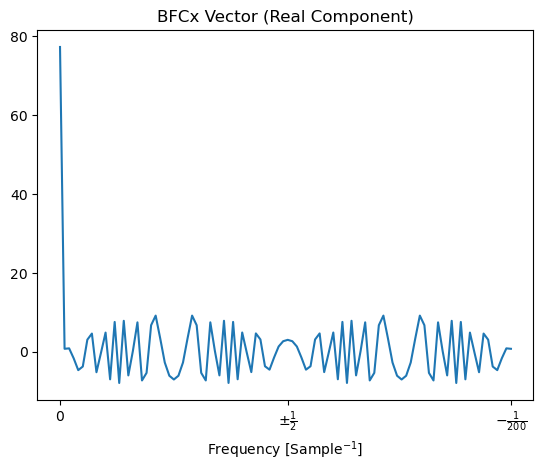

In [215]:
plt.title(f"BFCx Vector (Real Component)")
plt.plot(np.real(chirp_BFCx), label="FCx")
plt.xlabel(r"Frequency [Sample$^{-1}$]")
plt.xticks([0,50,99], labels=['0', r'$\pm \frac{1}{2}$', r'$- \frac{1}{200}$'])